# Imports

In [142]:
import json
import requests
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup

import numpy as np
import pandas as pd

from sklearn.preprocessing import OneHotEncoder

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

# Import dataframes

## Heroes id

In [2]:
f = open('data/hero_id.json',)
data = json.load(f)['heroes']
heroes = pd.read_json(json.dumps(data))
heroes.drop(['name'],axis=1,inplace=True)
heroes.set_index('id',inplace=True)
hero_id_dict = dict(heroes['localized_name'].to_dict())
items = hero_id_dict.items()
names = sorted(items)
hero_id_dict = dict(names)

## Matches id

In [143]:
#get match draft
matches = pd.read_csv('data/match.csv').drop(['leaguename','account_id'],axis=1)
match_ids = list(matches['match_id'].unique())

hero_ids = []
wins = []

for match_id in match_ids:
    hero_ids_match = list(matches[matches['match_id']==match_id]['hero_id'].values)
    hero_ids.append(hero_ids_match)
    win = int(matches[matches['match_id']==match_id]['win'].values[-1])
    wins.append(win)

hero_ids = np.array(hero_ids).reshape((len(hero_ids),10))

matches = pd.DataFrame(columns= 'rad_1 rad_2 rad_3 rad_4 rad_5 dire_1 dire_2 dire_3 dire_4 dire_5 win'.split())
matches['win'] = wins
matches[matches.columns[:10]] = hero_ids

# def id2name(hero_id):
#     try:
#         return hero_id_dict[hero_id]
         
#     except:
#         return None

# for i in range(10):
#     matches[matches.columns[i]] = matches[matches.columns[i]].apply(lambda x: id2name(x))
    
#get banned picks
# bans = []
# for match_id in match_ids:

#     url = f'https://api.steampowered.com/IDOTA2Match_570/GetMatchDetails/V001/?match_id={match_id}&key=8DFCD225B2187AFFC656BC1369FE7295'
#     response = urlopen(url)
#     data = json.loads(response.read())
#     try:
#         data = data['result']['picks_bans']
#         bans_df = pd.read_json(json.dumps(data))
#         bans_match = bans_df[bans_df['is_pick']==False]['hero_id'].values
#         bans.append(bans_match)
#     except:
#         bans.append([None for i in range(14)])
    
# bans

matches

,rad_1,rad_2,rad_3,rad_4,rad_5,dire_1,dire_2,dire_3,dire_4,dire_5,win
0,4,61,52,102,110,126,79,38,1,9,0
1,57,9,106,18,38,112,91,81,52,100,0
2,44,97,104,25,85,126,10,92,129,53,0
3,4,18,57,121,22,91,6,107,10,28,1
4,85,61,51,70,110,5,13,19,109,33,0
...,...,...,...,...,...,...,...,...,...,...,...
4411,95,97,120,27,110,8,69,129,26,58,0
4412,39,86,129,63,100,58,114,11,110,20,0
4413,42,23,129,110,58,95,43,13,100,85,1
4414,5,114,126,110,16,100,25,96,9,91,0


# Analysing data

## Most picked heroes

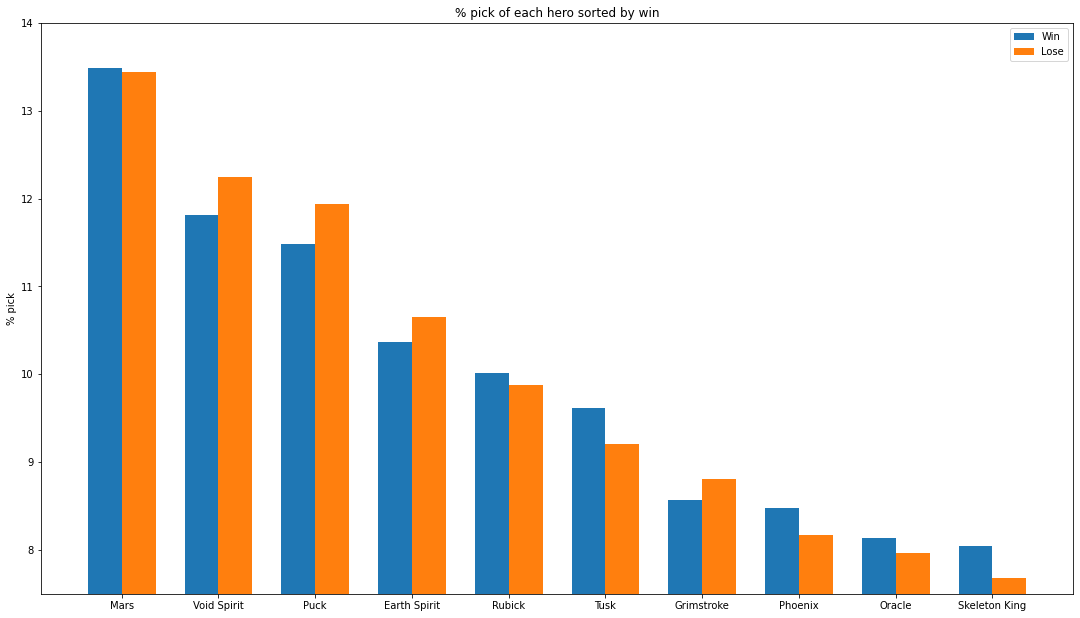

In [101]:
picks_win = matches[matches['win']==1].iloc[:,:10].values
unique_win, counts_win = np.unique(picks_win, return_counts=True)
picks_win_count = dict(zip(unique_win, counts_win))
picks_win_count = dict(sorted(picks_win_count.items(), key=lambda item: item[1], reverse=True))

top = 10

heroes_win = list(picks_win_count.keys())[:top]
count_win = np.array(list(picks_win_count.values())[:top])
count_win = count_win/count_win.sum()*100

picks_lose = matches[matches['win']==0].iloc[:,:10].values
unique_lose, counts_lose = np.unique(picks_lose, return_counts=True)
picks_lose_count = dict(zip(unique_lose, counts_lose))
picks_lose_count = dict(sorted(picks_lose_count.items(), key=lambda item: item[1], reverse=True))
heroes_lose = list(picks_lose_count.keys())[:top]
count_lose = np.array(list(picks_lose_count.values())[:top])
count_lose = count_lose/count_lose.sum()*100

labels = [hero_id_dict[hero] for hero in heroes_win]

x = np.arange(top)  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(18.5, 10.5)
rects1 = ax.bar(x - width/2, count_win, width, label='Win')
rects2 = ax.bar(x + width/2, count_lose, width, label='Lose')

ax.set_ylabel('% pick')
ax.set_title('% pick of each hero sorted by win')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.set_ylim(ymin=7.5,ymax=14);

## Top 10 win rates by hero

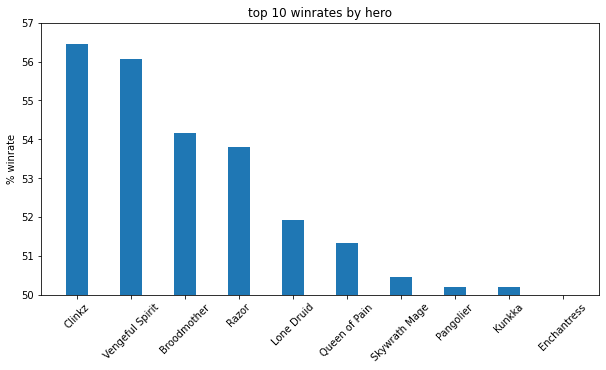

In [99]:
ids = list(hero_id_dict.keys())
winrates = []

for idx in ids:
    wins_hero = 0.0
    total_hero = 0.0
    for i in range(10):
        wins_hero += matches[matches[matches.columns[i]]==idx]['win'].sum()
        total_hero += len(matches[matches[matches.columns[i]]==idx]['win'])
    winrate = wins_hero/total_hero
    winrates.append(winrate)
    
winrate_dict = dict(zip(ids,winrates))
winrate_dict = dict(sorted(winrate_dict.items(), key=lambda item: item[1], reverse=True))
heroes_winrate = list(winrate_dict.keys())[:top]
winrates = np.array(list(winrate_dict.values())[:top])*100

labels = [hero_id_dict[hero] for hero in heroes_winrate]

x = np.arange(top)  # the label locations
width = 0.4  # the width of the bars

fig, ax = plt.subplots()
fig.set_size_inches(10, 5)
rects = ax.bar(x, winrates, width)

ax.set_ylabel('% winrate')
ax.set_title(f'top {top} winrates by hero')
ax.set_xticks(x)
ax.set_xticklabels(labels, rotation = 45)
ax.set_ylim(ymin=50,ymax=57);

## Graphs Visualization

# Machine Learning - https://arxiv.org/pdf/1806.10130.pdf

## Prepare dataframe

In [158]:
X = []
Y = []
for i in range(len(matches)):
    if matches.iloc[i,-1]:
        X.append(list(matches.iloc[i,:5].values))
        Y.append(list(matches.iloc[i,5:10].values))
    else:
        Y.append(list(matches.iloc[i,:5].values))
        X.append(list(matches.iloc[i,5:10].values))
        
X = np.array(X).reshape((len(X),5))
Y = np.array(Y).reshape((len(Y),5))
enc = OneHotEncoder(handle_unknown='ignore')
X = enc.fit_transform(X)
X

<4416x595 sparse matrix of type '<class 'numpy.float64'>'
	with 22080 stored elements in Compressed Sparse Row format>

In [164]:
X

<4416x595 sparse matrix of type '<class 'numpy.float64'>'
	with 22080 stored elements in Compressed Sparse Row format>